In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms 
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

copy from [Maxout Networks](https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb)
<br>
pytorch 0.4.0

In [4]:
learning_rate = 0.0001
batch_size = 50
n_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

Processing...
Done!


In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

In [7]:
class rectifier_mlp(nn.Module):
    def __init__(self):
        super(rectifier_mlp, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout()

    def forward(self, x): 
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
class maxout_mlp(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_mlp, self).__init__()
        self.fc1_list = nn.ModuleList()
        self.fc2_list = nn.ModuleList()
        self.dropout = nn.Dropout()
        for _ in range(num_units):
            self.fc1_list.append(nn.Linear(784, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = x.view(-1, 784)
        x = self.maxout(x, self.fc1_list)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        return x

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output

In [36]:
def train(epoch,  net, train_loss, train_acc): 
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader): 
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = prediction.eq(target.data).sum().float()/batch_size*100.0 
        train_acc.append(accuracy)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [37]:
def test(epoch, net):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()

        test_loss = test_loss
        test_loss /= len(test_loader) # loss function already averages over batch size
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [38]:
mlp_relu = rectifier_mlp().to(device)
relu_mlp_loss = [] 
relu_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_relu, relu_mlp_loss, relu_mlp_acc)
    test(epoch, mlp_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.333392
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.668069
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.383142
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.519796
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.250225
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.424916
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.197328
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.400900
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.408135
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.160900
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.280716
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.285703

Test set: Average loss: 0.2135, Accuracy: 9393/10000 (93%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.123724
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.132765
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.170325
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.330656
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.170931
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.206825
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.259060
Tra

In [39]:
mlp_maxout = maxout_mlp(num_units=5).to(device)
maxout_mlp_loss = [] 
maxout_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_maxout, maxout_mlp_loss, maxout_mlp_acc)
    test(epoch, mlp_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.341381
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.765297
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.424273
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.275276
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.377032
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.338851
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.155935
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.227752
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.123138
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.145293
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.202979
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.250366

Test set: Average loss: 0.1365, Accuracy: 9624/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.139623
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.052591
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.043543
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.096602
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.054987
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.101092
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.051419
Tra

In [43]:
class rectifier_conv_net(nn.Module):
    def __init__(self):
        super(rectifier_conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)  # zero-padding added to both side of the input
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout()

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # [B, 32, 14, 14]
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # [B, 64, 7, 7]
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
class maxout_conv_net(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_conv_net, self).__init__()
        self.conv1_list = nn.ModuleList()
        self.conv2_list = nn.ModuleList()
        self.fc1_list = nn.ModuleList()
        self.fc2_list = nn.ModuleList()
        self.dropout = nn.Dropout()
        for _ in range(num_units):
            self.conv1_list.append(nn.Conv2d(1, 32, 5, padding=2))
            self.conv2_list.append(nn.Conv2d(32, 64, 5, padding=2))
            self.fc1_list.append(nn.Linear(64*7*7, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = F.max_pool2d(self.maxout(x, self.conv1_list), 2)
        x = F.max_pool2d(self.maxout(x, self.conv2_list), 2)
        x = x.view(-1, 64*7*7)
        x = self.maxout(x, self.fc1_list)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        return x

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output

In [45]:
net_relu = rectifier_conv_net().to(device)
relu_loss = [] 
relu_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_relu, relu_loss, relu_acc)
    test(epoch, net_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312882
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.543504
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.199146
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.355826
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.198580
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.113778
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.117420
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.207189
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.060757
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.302293
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.109785
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.031707

Test set: Average loss: 0.0743, Accuracy: 9773/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.088204
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.112422
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.048545
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.110222
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.078297
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.037116
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.026240
Tra

In [52]:
net_maxout = maxout_conv_net(num_units=5).to(device)
maxout_loss = [] 
maxout_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_maxout, maxout_loss, maxout_acc)
    test(epoch, net_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.360562
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.295352
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.196501
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.160406
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.092157
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.029004
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.055983
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.080423
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.043930
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.051483
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.172550
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.166261

Test set: Average loss: 0.0424, Accuracy: 9862/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.072736
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.061517
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.255888
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.147335
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.071280
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.007710
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.087302
Tra

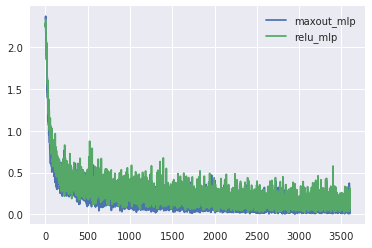

In [53]:
sns.set()
plot1, = plt.plot(maxout_mlp_loss, label='maxout_mlp')
plot2, = plt.plot(relu_mlp_loss, label='relu_mlp')
plt.legend(handles=[plot1, plot2])

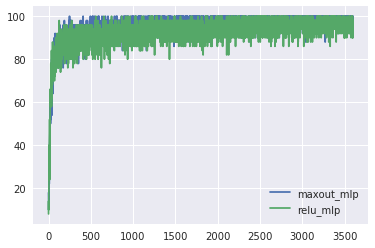

In [54]:
plot1, = plt.plot(maxout_mlp_acc, label='maxout_mlp')
plot2, = plt.plot(relu_mlp_acc, label='relu_mlp')
plt.legend(handles=[plot1, plot2])